In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
import math
from scipy.stats import linregress
from matplotlib.offsetbox import AnchoredText

sys.path.append('../../Classes')
from DataHandler import DataHandler
from NNModelTrainer import NNModelTrainer
from NNModelTester import NNModelTester

### Data + Model training + Tests

In [71]:
data = DataHandler(validation_sample= True, features_txt= 'all_features.txt', fields_list=['W02', 'W03', 'W04'], balance= 'weights')
data.main()

Members: 202787 (32.69%)
Non members: 417621 (67.31%)
----------------------------------------------------------------------
Training: 141951 members, 292334 non members
Validation: 42585 members, 87701 non members
Testing: 18251 members, 37586 non members
----------------------------------------------------------------------


In [72]:
layers_s_dropout = [
    tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ]

compile_params = dict(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics=[]   
    )

mod = NNModelTrainer(layers= layers_s_dropout, name= 'model_6', data= data, compile_params= compile_params)
# mod.train_model()
mod.load_model() # if model is already trained

In [73]:
test = NNModelTester(model= mod.model, data= data, name= 'model_6', history= mod.history)
test.predict()
test.curves()
test.write_report(extra_args= mod.args(), to_file = False)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 61)               123       
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                3968      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                      

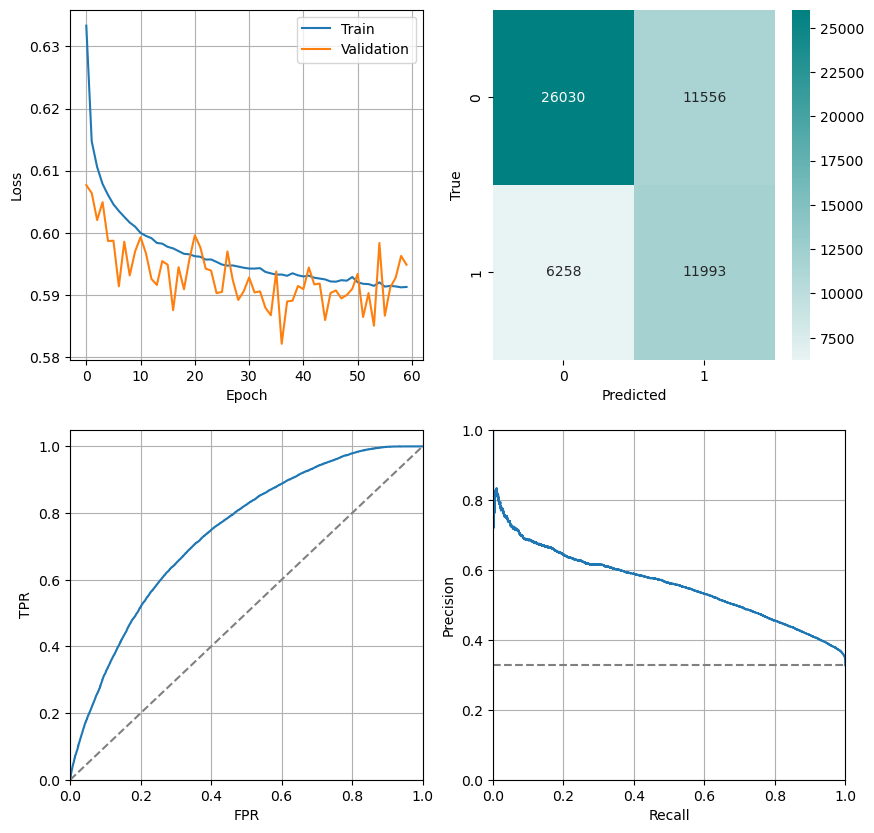

In [74]:
test.plot_report(to_file = False)

### Color magnitude plots: truth vs prediction

In [75]:
df_cl = pd.read_table('../../DATA/clusters.dat', delim_whitespace=True, usecols=[0,5],  names=['id_cl','phot_z_cl'])
#  usecols=[0,3,4,5,9,11,12],  names=['id_cl','ra_cl','dec_cl','phot_z_cl', 'r500_cl','mass_cl','n500_cl']

df_ = pd.DataFrame()
df_['id_cl_near_eval'] = [eval(p)[0] for p in data.testing.id_cl_near.values]
df_['z_cl'] = [df_cl[df_cl.id_cl == i]['phot_z_cl'].values[0] for i in df_.id_cl_near_eval]

In [76]:
min_ = 0.
max_ = 1.4
step = 0.2
n_bins = round((max_ - min_)/step)
z_centers = np.linspace(min_ + step/2., max_ - step/2., n_bins)
z_lims = np.linspace(min_, max_, n_bins + 1)

print(z_centers)
print(z_lims)

[0.1 0.3 0.5 0.7 0.9 1.1 1.3]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4]


In [100]:
def sub_func_col_mag(magnitude1, magnitude2, clim, mlim, nmem, mem, nmem_sam, z, i, typ):
    plt.subplot(n_bins, 2, i)
    sns.scatterplot(y = nmem[magnitude1] - nmem[magnitude2], x = nmem[magnitude2], marker = '+', alpha = 0.3, color = 'grey', zorder = 1,  label = 'Non-members')
    sns.kdeplot(y = nmem_sam[magnitude1] - nmem_sam[magnitude2], x = nmem_sam[magnitude2], levels = 8, color = 'grey', zorder = 2)
    sns.scatterplot(y = mem[magnitude1] - mem[magnitude2], x = mem[magnitude2], marker = '+', alpha = 0.3, label = 'Members', color = 'indigo', zorder = 3)
    
    plt.grid()
    plt.xlabel(f'{magnitude2}')
    plt.ylabel(f'{magnitude1} - {magnitude2}')
    plt.ylim(clim)
    plt.xlim(mlim)
    plt.title(f'{z - step/2 :.1f} < z < {z + step/2 :.1f} ({typ})')

    fit = linregress(mem[magnitude2].values, mem[magnitude1].values - mem[magnitude2].values)
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = fit[1] + fit[0] * x_vals
    plt.plot(x_vals, y_vals, ls = '--', color = 'indigo')

    text = f'slope: {fit.slope :.3f} +/- {fit.stderr :.3f}\nintercept: {fit.intercept :.3f} +/- {fit.intercept_stderr :.3f}'
    text_box = AnchoredText(text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)

def col_mag(magnitude1, magnitude2, clim, mlim, sample = 1000):
    plt.figure(figsize = (9, 4.*n_bins))

    for i_z,z in enumerate(z_centers):
        
        cond = (df_.z_cl > z - step/2. ) & (df_.z_cl < z+step/2. )
        cond = cond.values

        # truth
        mem = data.testing[(data.testing.member == 1) & (cond)]
        nmem = data.testing[(data.testing.member == 0) & cond]
        try:
            nmem_sam = nmem.sample(n = sample, axis = 'index') # contour plot takes forever. use sample
        except:
            nmem_sam = nmem
        plt.subplot(n_bins, 2, i_z+1)
        sub_func_col_mag(magnitude1, magnitude2, clim, mlim, nmem, mem, nmem_sam, z, i_z*2+1, 'Truth')

        # prediction
        mem = data.testing[(test.predictions.flatten() == 1) & cond] 
        nmem = data.testing[(test.predictions.flatten() == 0) & cond]
        try:
            nmem_sam = nmem.sample(n = sample, axis = 'index') # contour plot takes forever. use sample
        except:
            nmem_sam = nmem
        sub_func_col_mag(magnitude1, magnitude2, clim, mlim, nmem, mem, nmem_sam, z, i_z*2+2, 'Prediction')
    plt.tight_layout(h_pad = 1.2)
    plt.show()

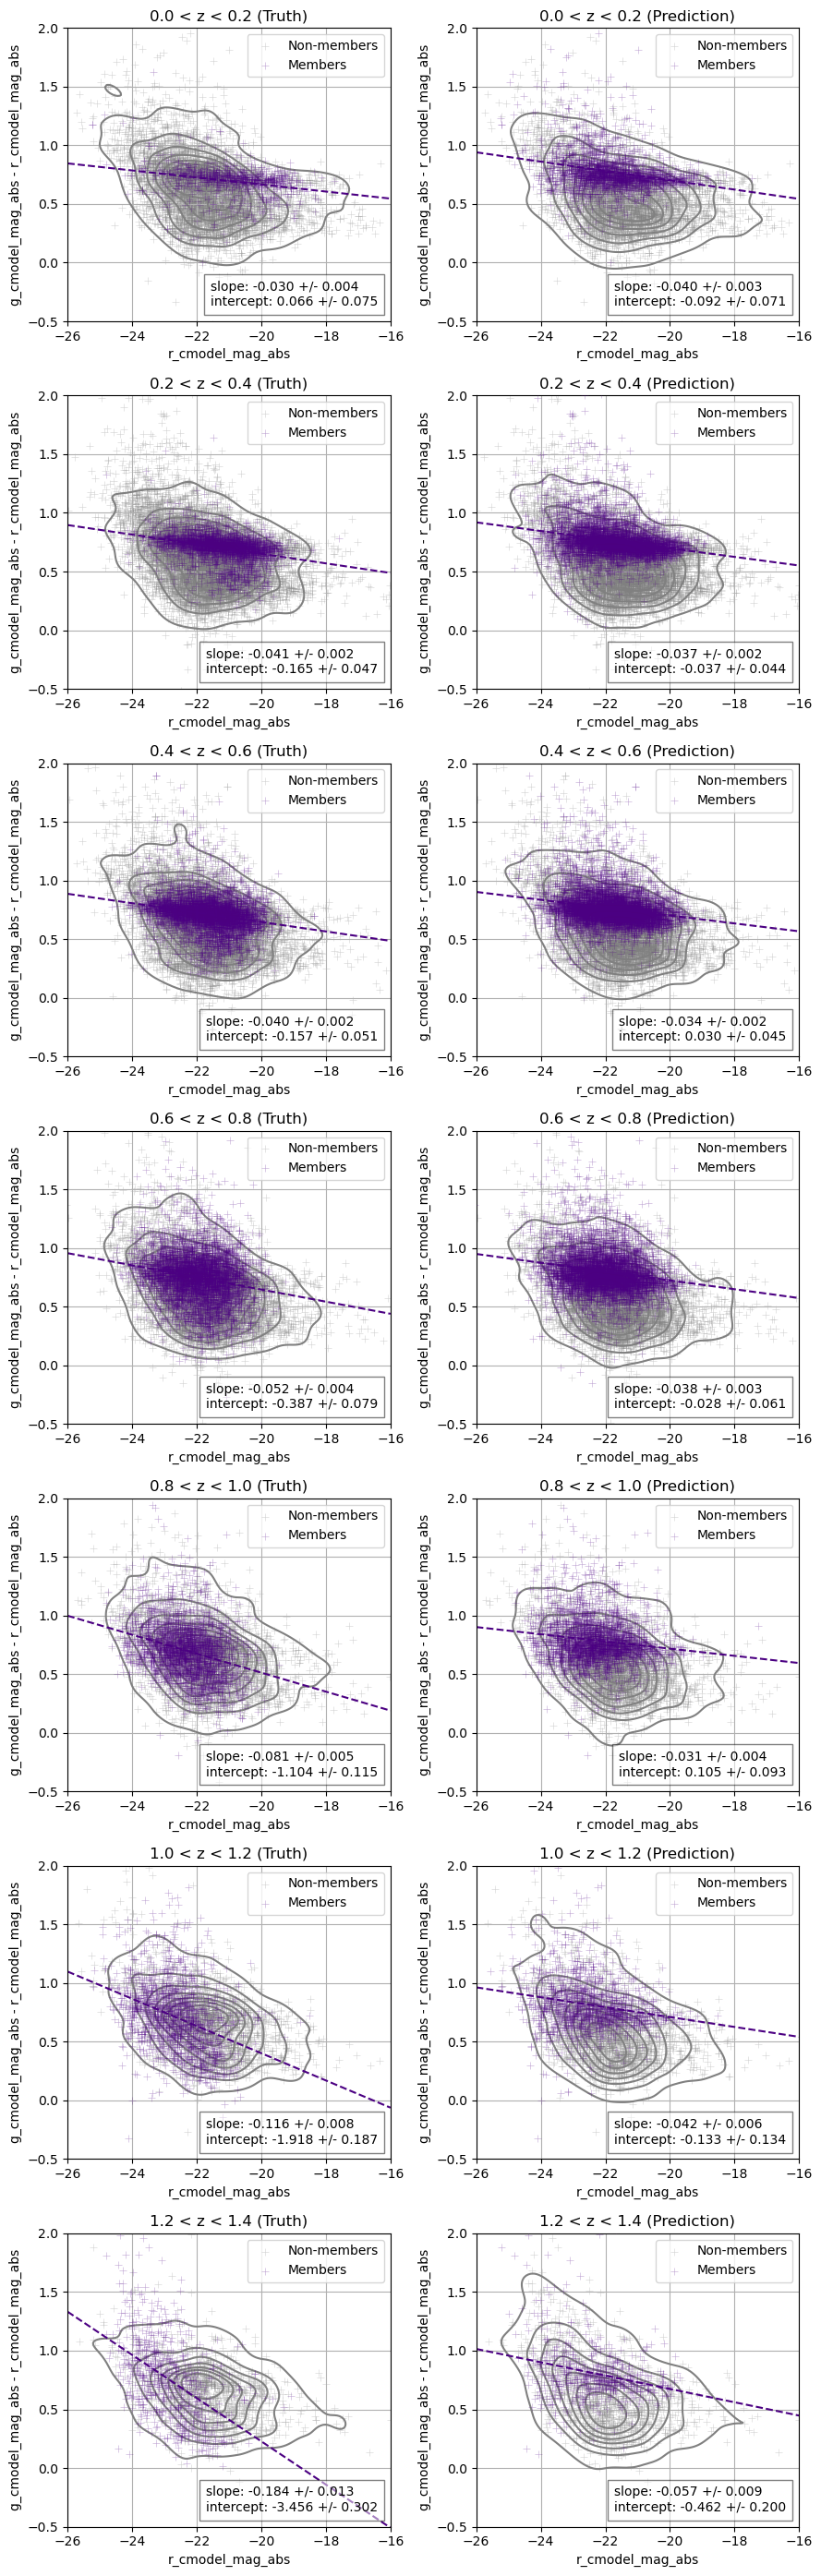

In [101]:
col_mag('g_cmodel_mag_abs', 'r_cmodel_mag_abs', (-0.5, 2.), (-26,-16))

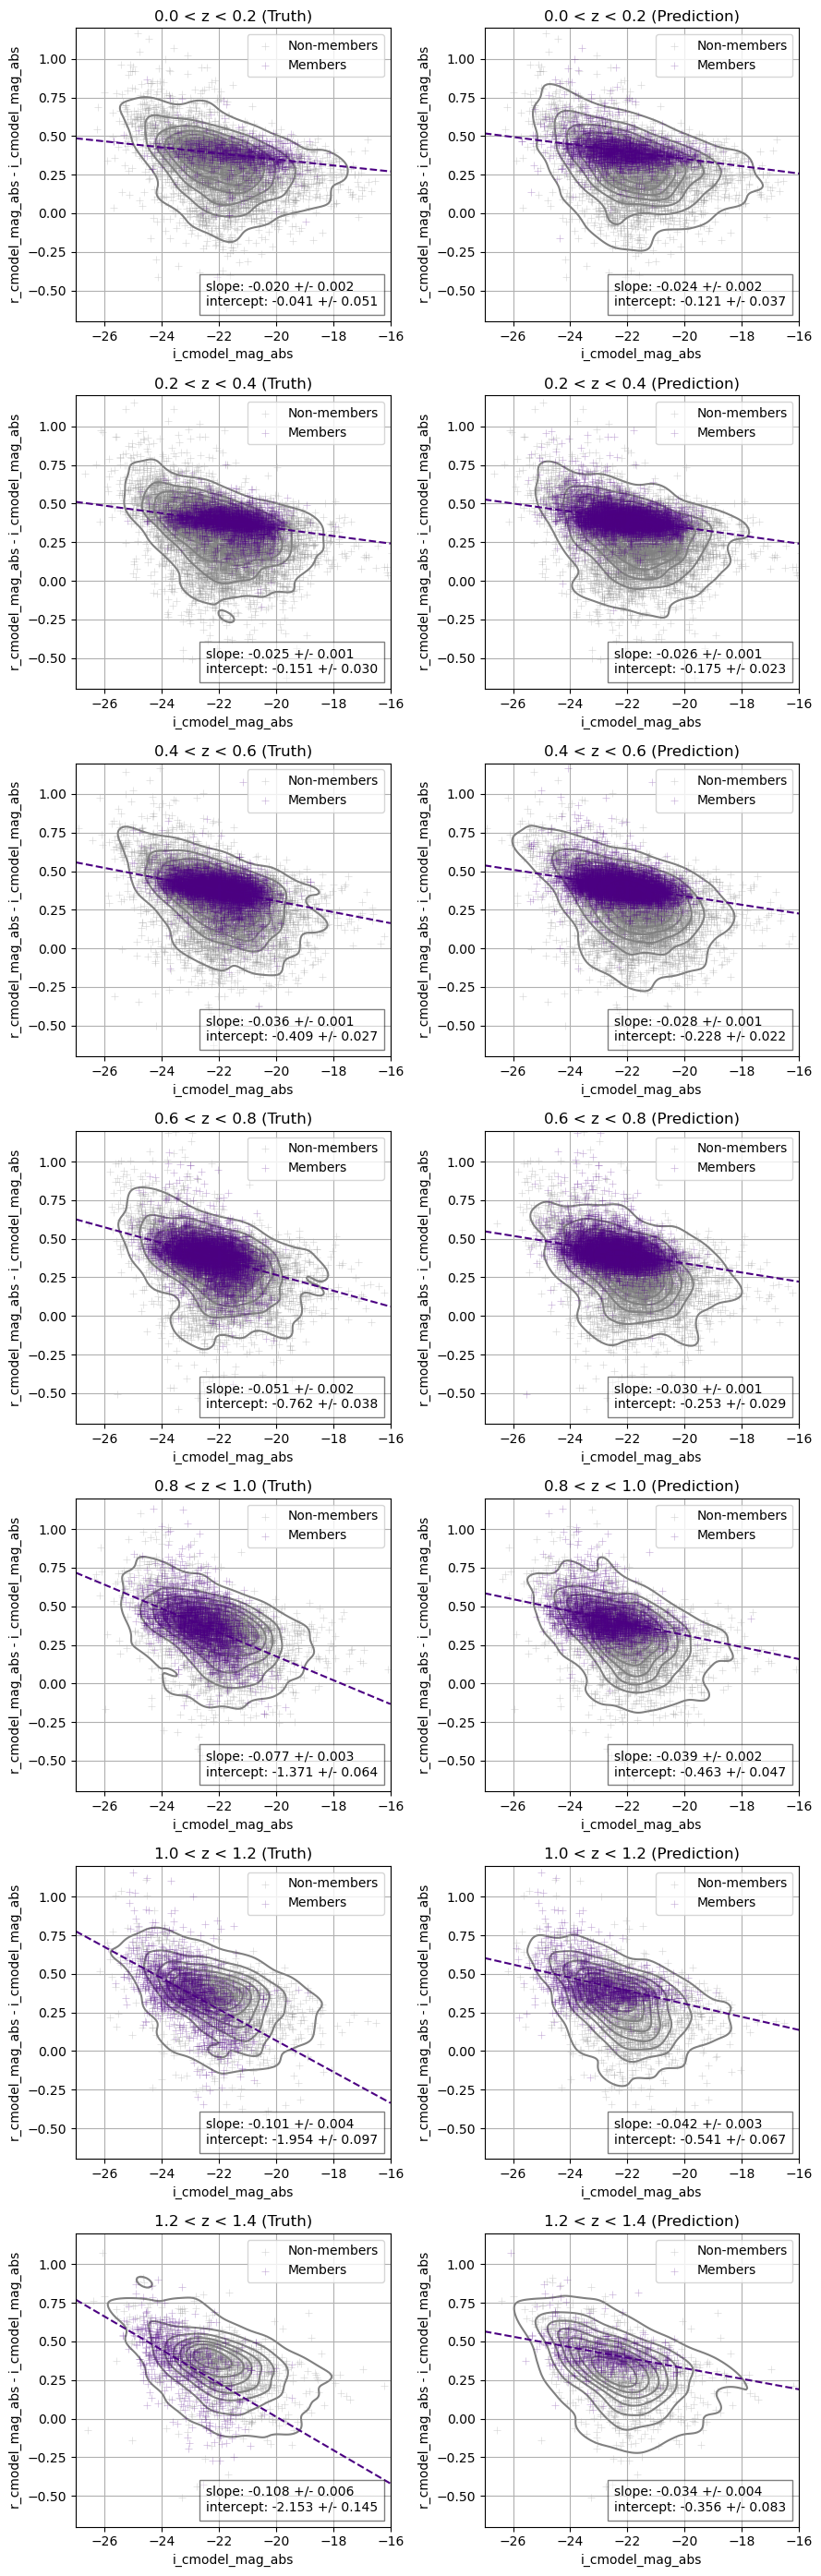

In [102]:
col_mag('r_cmodel_mag_abs', 'i_cmodel_mag_abs', (-0.7, 1.2), (-27,-16))